# Room Connection and Door Position Predicting Models

This notebook contains two models:
- The first model predicts the probability that two rooms are connected
- The second model predicts the position of the door between the two rooms

Together these models can predict if two rooms are connected and where the door connecting them would be.

### Room Connection Random Forest Model
- **Model Type:** Random forest classification
- **Data/Input:** All possible room connections of rooms in the same apartment, across many apartments. Relevant information such as room type is included. Extracted using a Cypher query.
- **Hyperparameter Tuning:** GridSearch CV sufficient
- **Label Predicted:** Probably that two rooms are connected or not. 0.5 threshold, 0 - not connected, 1 - connected
- **Results:** Testing accuracy = 95.7%

### Door Position XGBoost Model
The second model is XGBoost regression model. A dataframe containing information on all rooms and their door positions and other relevant information is extracted using a Cypher query. This is the training data for the second model. The model is trained and outputs a prediction of the door position given two connected rooms. The validation R² value is 0.99 when trained on all features or when trained on only the 5 most important features.

- **Model Type:** XGBoost regression
- **Data/Input:** All doors and information about the 2 rooms they are connecting. Relevant information such as room areas and positions are included. Extracted using a Cypher query.
- **Hyperparameter Tuning:** GridSearch CV is sufficient
- **Label Predicted:** Door position (x,y)
- **Results:** R² value = 0.992 when trained on all features and 0.994 when trained on only the 5 most important features

#### Feature Importance
The majority of the features added during feature engineering and data preprocessing are not relatively important to the model. Through observing the feature importances, the most important features are location information of the rooms and the difference in area of the two rooms. All other features have little to no impact on the model and can be removed.

#### Dataset Size Requirements
XGBoost is powerful in its ablity to preform well on small datasets. The number of training datapoints needed to reach a R² value of 0.5 is 19 datapoints. 57 are needed to reach 0.75, 133 for 0.9, and 1163 for 0.99.

**Setup**

In [112]:
# Connecting with neo4j
%pip install graphdatascience

In [113]:
from graphdatascience import GraphDataScience
gds = GraphDataScience("neo4j+s://e387fb5e.databases.neo4j.io", auth=("neo4j", "4gTtzES2v475jIDDky7Aj4ry2JY9jULB7E5UNchOEjg"), aura_ds=True)

In [114]:
from graphdatascience.server_version.server_version import ServerVersion
assert gds.server_version() >= ServerVersion(1, 8, 0)

In [115]:
# Necessary imports
import numpy as np
import pandas as pd
from graphdatascience import GraphDataScience
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

**Connection Predicting Model**

Data Querying & Cleaning

In [155]:
# Query to obtain all possible room pair combinations of rooms in the same apartment and additional room information
feature_query = """
MATCH (r1:Room), (r2:Room)
WHERE id(r1) < id(r2) AND r1.apartment_id = r2.apartment_id  // Rooms in the same apartment
RETURN
    r1.id AS room1_id, r2.id AS room2_id,
    r1.area AS room1_area, r2.area AS room2_area,
    r1.elevation AS room1_elevation, r2.elevation AS room2_elevation,
    r1.height AS room1_height, r2.height AS room2_height,
    r1.entity_subtype AS room1_type, r2.entity_subtype AS room2_type,
    r1.zoning AS room1_zoning, r2.zoning AS room2_zoning,
    r1.unit_usage AS room1_usage, r2.unit_usage AS room2_usage,
    point.distance(point({x: r1.pos[0], y: r1.pos[1]}),
                   point({x: r2.pos[0], y: r2.pos[1]})) AS distance,
    CASE WHEN (r1)-[:CONNECTED_TO]-(r2) THEN 1 ELSE 0 END AS is_connected
"""

# Run query and prepare data
rooms_df = gds.run_cypher(feature_query)

In [156]:
# Observe dataframe, the label we're predicting is is_connected
rooms_df.head(10)

,room1_id,room2_id,room1_area,room2_area,room1_elevation,room2_elevation,room1_height,room2_height,room1_type,room2_type,room1_zoning,room2_zoning,room1_usage,room2_usage,distance,is_connected
0,18202,18203,19.461256,6.554867,5.8,5.8,2.6,2.6,LIVING_ROOM,BATHROOM,Zone2,Zone3,RESIDENTIAL,RESIDENTIAL,7.122677,0
1,18202,18204,19.461256,8.830383,5.8,5.8,2.6,2.6,LIVING_ROOM,BALCONY,Zone2,Zone4,RESIDENTIAL,RESIDENTIAL,5.007028,0
2,18203,18204,6.554867,8.830383,5.8,5.8,2.6,2.6,BATHROOM,BALCONY,Zone3,Zone4,RESIDENTIAL,RESIDENTIAL,7.961203,0
3,18202,18205,19.461256,18.889749,5.8,5.8,2.6,2.6,LIVING_ROOM,LIVING_ROOM,Zone2,Zone2,RESIDENTIAL,RESIDENTIAL,7.089975,0
4,18203,18205,6.554867,18.889749,5.8,5.8,2.6,2.6,BATHROOM,LIVING_ROOM,Zone3,Zone2,RESIDENTIAL,RESIDENTIAL,4.247436,0
5,18204,18205,8.830383,18.889749,5.8,5.8,2.6,2.6,BALCONY,LIVING_ROOM,Zone4,Zone2,RESIDENTIAL,RESIDENTIAL,5.030359,0
6,18202,18208,19.461256,11.498035,5.8,5.8,2.6,2.6,LIVING_ROOM,KITCHEN,Zone2,Zone2,RESIDENTIAL,RESIDENTIAL,3.662569,0
7,18203,18208,6.554867,11.498035,5.8,5.8,2.6,2.6,BATHROOM,KITCHEN,Zone3,Zone2,RESIDENTIAL,RESIDENTIAL,5.421074,0
8,18204,18208,8.830383,11.498035,5.8,5.8,2.6,2.6,BALCONY,KITCHEN,Zone4,Zone2,RESIDENTIAL,RESIDENTIAL,2.700847,1
9,18205,18208,18.889749,11.498035,5.8,5.8,2.6,2.6,LIVING_ROOM,KITCHEN,Zone2,Zone2,RESIDENTIAL,RESIDENTIAL,3.629238,0


In [7]:
rooms_df.shape

(115264, 16)

In [157]:
# Prepare features
X = rooms_df.drop(['room1_id', 'room2_id', 'is_connected'], axis=1)
y = rooms_df['is_connected']

# Define features
numeric_features = ['room1_area', 'room2_area', 'room1_elevation', 'room2_elevation',
                    'room1_height', 'room2_height', 'distance']
categorical_features = ['room1_type', 'room2_type', 'room1_zoning', 'room2_zoning',
                        'room1_usage', 'room2_usage']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Grid Search Cross Validation & Model Training

*Uncomment to run cross validation again*


In [121]:
# # Uncomment to run CV again
# # Create a pipeline
# clf = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# # Define parameter grid
# param_grid = {
#     'classifier__n_estimators': [50, 100, 200],
#     'classifier__max_depth': [None, 10, 20, 30],
#     'classifier__min_samples_split': [2, 5, 10],
#     'classifier__min_samples_leaf': [1, 2, 4]
# }

# # Create GridSearchCV object
# grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# # Print best parameters and score
# print("Best parameters:", grid_search.best_params_) # {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
# print("Best cross-validation score:", grid_search.best_score_)
# best_params = grid_search.best_params_

# # Evaluate on test set
# best_model = grid_search.best_estimator_
# test_score = best_model.score(X_test, y_test)
# print("Test set score:", test_score)

In [158]:
# Save best parameters
best_params = {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# Create a pipeline with the best parameters
best_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, **best_params))
])

# Fit the model
best_clf.fit(X_train, y_train) #146 seconds

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['room1_area', 'room2_area',
                                                   'room1_elevation',
                                                   'room2_elevation',
                                                   'room1_height',
                                                   'room2_height',
                                                   'distance']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room1_type', 'room2_type',
                                                   'room1_zoning',
                                                   'room2_zoning',
                                                   'room1_usage',
                                                   'room2_usage'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=30, n_estimators=200,
                                        random_state=42))])

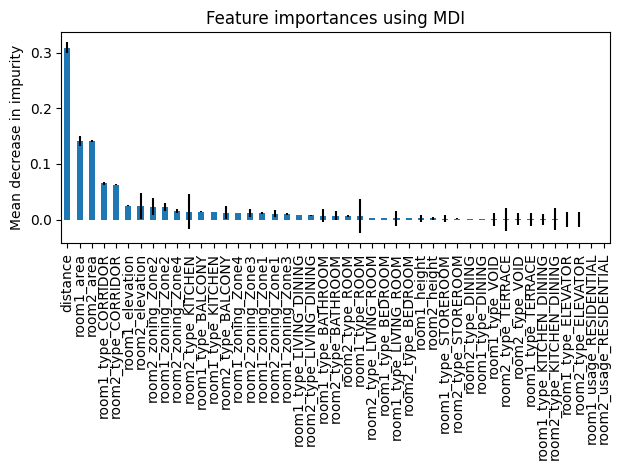

In [160]:
# Observe feature importance

# Extract the trained classifier from the pipeline
trained_classifier = best_clf.named_steps['classifier']

# Calculate feature importances
importances = trained_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in trained_classifier.estimators_], axis=0)

# Extract feature names from the preprocessor
numeric_feature_names = numeric_features
categorical_feature_names = best_clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Create a pandas Series for the feature importances
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

# Plot the feature importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

Accuracy & Testing

In [131]:
# Evaluate the model/observe accuracy
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred)) # usually ~95%

Classification Accuracy: 0.9569253459419599

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     18266
           1       0.91      0.88      0.89      4787

    accuracy                           0.96     23053
   macro avg       0.94      0.93      0.93     23053
weighted avg       0.96      0.96      0.96     23053



In [132]:
# Observe class imbalance to ensure good results are not due to severe class imbalance
y.value_counts()

,count
is_connected,
0,91421
1,23843


In [133]:
23843/(23843+91421)

0.20685556635202665

In [134]:
# Queries information from neo4j of two rooms and runs trained model on them & their info.
# Returns None if rooms are not found and the predicted probablity otherwise
def predict_connection(room1_id, room2_id):
    # Query to fetch features for the two rooms
    query = f"""
    MATCH (r1:Room {{id: '{room1_id}'}}), (r2:Room {{id: '{room2_id}'}})
    WHERE r1.apartment_id = r2.apartment_id
    RETURN
        r1.area AS room1_area, r2.area AS room2_area,
        r1.elevation AS room1_elevation, r2.elevation AS room2_elevation,
        r1.height AS room1_height, r2.height AS room2_height,
        r1.entity_subtype AS room1_type, r2.entity_subtype AS room2_type,
        r1.zoning AS room1_zoning, r2.zoning AS room2_zoning,
        r1.unit_usage AS room1_usage, r2.unit_usage AS room2_usage,
        point.distance(point({{x: r1.pos[0], y: r1.pos[1]}}),
                       point({{x: r2.pos[0], y: r2.pos[1]}})) AS distance
    """
    # NOTE: id's are stored as strings in neo4j

    features = gds.run_cypher(query)

    if features.empty:
        print(f"Rooms with IDs {room1_id} and {room2_id} not found in the same apartment.")
        return None  # Return None if rooms not found or not in same apartment

    # Use the trained Random Forest model to make a prediction
    connection_prob = best_clf.predict_proba(features)[0][1]
    return connection_prob

In [135]:
# Example usage

# Known that these are connected
room1_id = 171963
room2_id = 171959

prob = predict_connection(room1_id, room2_id)
print(prob) # 0.969 correct
assert(prob >= 0.5)

0.9694681376529823


In [136]:
# Known that these aren't connected
room1_id = 82942
room2_id = 82944

prob = predict_connection(room1_id, room2_id)
print(prob) # 0.185 correct
assert(prob < 0.5)

0.185


In [137]:
# Not in the same apartment, expecting none
room1_id = 82938
room2_id = 192725

prob = predict_connection(room1_id, room2_id)
print(prob)
assert(prob == None)

Rooms with IDs 82938 and 192725 not found in the same apartment.
None


**Door Position Predicting Model**

Data Querying & Cleaning

In [161]:
# Query to get data for connected rooms and their door positions
doors_query = """
    MATCH (r1:Room)-[c:CONNECTED_TO]->(r2:Room)
    WHERE id(r1) < id(r2)
    RETURN
        r1.id AS room1_id, r2.id AS room2_id,
        r1.area AS room1_area, r2.area AS room2_area,
        r1.elevation AS room1_elevation, r2.elevation AS room2_elevation,
        r1.height AS room1_height, r2.height AS room2_height,
        r1.entity_subtype AS room1_type, r2.entity_subtype AS room2_type,
        r1.zoning AS room1_zoning, r2.zoning AS room2_zoning,
        r1.unit_usage AS room1_usage, r2.unit_usage AS room2_usage,
        r1.pos AS room1_pos, r2.pos AS room2_pos,
        c.door_pos AS door_pos
    """

In [162]:
# Fetch data
doors_df = gds.run_cypher(doors_query)

In [163]:
doors_df.head(10)

,room1_id,room2_id,room1_area,room2_area,room1_elevation,room2_elevation,room1_height,room2_height,room1_type,room2_type,room1_zoning,room2_zoning,room1_usage,room2_usage,room1_pos,room2_pos,door_pos
0,18203,18209,6.554867,12.222848,5.8,5.8,2.6,2.6,BATHROOM,CORRIDOR,Zone3,Zone2,RESIDENTIAL,RESIDENTIAL,"[-3.8974557128286746, -11.451411704460378]","[-0.42937123230233937, -12.760798666503842]","[-2.928986638253374, -12.910339065493378]"
1,18204,18208,8.830383,11.498035,5.8,5.8,2.6,2.6,BALCONY,KITCHEN,Zone4,Zone2,RESIDENTIAL,RESIDENTIAL,"[-2.830957578996087, -19.34085596115299]","[-2.4296429708275533, -16.669990527416765]","[-2.676295225212301, -18.227619611196072]"
2,18205,18209,18.889749,12.222848,5.8,5.8,2.6,2.6,LIVING_ROOM,CORRIDOR,Zone2,Zone2,RESIDENTIAL,RESIDENTIAL,"[-5.774461670597268, -15.261603654803377]","[-0.42937123230233937, -12.760798666503842]","[-3.3247956606525477, -13.965238535349126]"
3,114015,114017,8.064509,26.193672,8.7,8.7,2.6,2.6,CORRIDOR,LIVING_DINING,Zone2,Zone2,RESIDENTIAL,RESIDENTIAL,"[2.2756754229430802, 0.7759719120119399]","[5.903437705425144, -1.8957949033417123]","[3.677590794569989, 0.7144348202848798]"
4,114015,114018,8.064509,16.564667,8.7,8.7,2.6,2.6,CORRIDOR,BEDROOM,Zone2,Zone1,RESIDENTIAL,RESIDENTIAL,"[2.2756754229430802, 0.7759719120119399]","[5.7383382125754885, 3.3928725297566356]","[3.642854449185587, 1.827151615524369]"
5,114015,114019,8.064509,6.756597,8.7,8.7,2.6,2.6,CORRIDOR,KITCHEN,Zone2,Zone2,RESIDENTIAL,RESIDENTIAL,"[2.2756754229430802, 0.7759719120119399]","[2.4018945652661716, 3.7619203733913698]","[3.642854449185587, 1.827151615524369]"
6,114015,114020,8.064509,3.282422,8.7,8.7,2.6,2.6,CORRIDOR,BATHROOM,Zone2,Zone3,RESIDENTIAL,RESIDENTIAL,"[2.2756754229430802, 0.7759719120119399]","[1.0266953237468412, -0.43823029238843]","[1.3497193513231414, 0.9123048040059886]"
7,114015,114021,8.064509,12.903793,8.7,8.7,2.6,2.6,CORRIDOR,BEDROOM,Zone2,Zone1,RESIDENTIAL,RESIDENTIAL,"[2.2756754229430802, 0.7759719120119399]","[1.9388325073318287, -3.386073591122375]","[3.1799303660162375, -1.4834027206638298]"
8,114016,114017,10.213593,26.193672,8.7,8.7,2.6,2.6,BALCONY,LIVING_DINING,Zone4,Zone2,RESIDENTIAL,RESIDENTIAL,"[6.338996887800072, -6.7637354380444545]","[5.903437705425144, -1.8957949033417123]","[5.013630016968761, -5.3218021341953285]"
9,114018,114019,16.564667,6.756597,8.7,8.7,2.6,2.6,BEDROOM,KITCHEN,Zone1,Zone2,RESIDENTIAL,RESIDENTIAL,"[5.7383382125754885, 3.3928725297566356]","[2.4018945652661716, 3.7619203733913698]","[3.642854449185587, 1.827151615524369]"


In [141]:
doors_df.shape

(23843, 17)

In [164]:
# Extract x and y coordinates from room positions
doors_df[['room1_pos_x', 'room1_pos_y']] = pd.DataFrame(doors_df['room1_pos'].tolist(), index=doors_df.index)
doors_df[['room2_pos_x', 'room2_pos_y']] = pd.DataFrame(doors_df['room2_pos'].tolist(), index=doors_df.index)
doors_df[['door_pos_x', 'door_pos_y']] = pd.DataFrame(doors_df['door_pos'].tolist(), index=doors_df.index)

# Feature engineering
def engineer_features(df):
    df['room_area_diff'] = df['room1_area'] - df['room2_area']
    df['room_height_diff'] = df['room1_height'] - df['room2_height']
    df['room_elevation_diff'] = df['room1_elevation'] - df['room2_elevation']
    df['room_pos_x_diff'] = df['room1_pos_x'] - df['room2_pos_x']
    df['room_pos_y_diff'] = df['room1_pos_y'] - df['room2_pos_y']
    return df

doors_df = engineer_features(doors_df)

# Prepare features and target
X = doors_df.drop(['room1_id', 'room2_id', 'room1_pos', 'room2_pos', 'door_pos', 'door_pos_x', 'door_pos_y'], axis=1)
y = doors_df[['door_pos_x', 'door_pos_y']]

# Define preprocessing steps
numeric_features = ['room1_area', 'room2_area', 'room1_elevation', 'room2_elevation', 'room1_height', 'room2_height',
                    'room1_pos_x', 'room1_pos_y', 'room2_pos_x', 'room2_pos_y',
                    'room_area_diff', 'room_height_diff', 'room_elevation_diff', 'room_pos_x_diff', 'room_pos_y_diff']
categorical_features = ['room1_type', 'room2_type', 'room1_zoning', 'room2_zoning', 'room1_usage', 'room2_usage']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Create a pipeline with the preprocessor and a MultiOutputRegressor with XGBRegressor
xgb_regr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(XGBRegressor(random_state=42)))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Training

*Uncomment to run cross validation again*

In [165]:
# # Uncomment to run CV again
# # Define parameter grid for GridSearchCV
# param_grid = {
#     'regressor__estimator__n_estimators': [100, 200, 300],
#     'regressor__estimator__max_depth': [3, 5, 7],
#     'regressor__estimator__learning_rate': [0.01, 0.1, 0.2],
#     'regressor__estimator__min_child_weight': [1, 3, 5]
# }

# # Perform GridSearchCV
# grid_search = GridSearchCV(xgb_regr, param_grid, cv=5, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)

# # Get best model
# best_model = grid_search.best_estimator_

# # Evaluate on test set
# y_pred = best_model.predict(X_test)
# test_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')

# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Test R^2 score: {test_r2}")
# best_params = grid_search.best_params_

In [166]:
# Create a new pipeline with the best parameters

best_params = {'regressor__estimator__learning_rate': 0.1, 'regressor__estimator__max_depth': 7, 'regressor__estimator__min_child_weight': 3, 'regressor__estimator__n_estimators': 300}

best_xgb_regr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(XGBRegressor(
        n_estimators=best_params['regressor__estimator__n_estimators'],
        max_depth=best_params['regressor__estimator__max_depth'],
        learning_rate=best_params['regressor__estimator__learning_rate'],
        min_child_weight=best_params['regressor__estimator__min_child_weight'],
        random_state=42
    )))
])

# Train the model on the entire training dataset
best_xgb_regr.fit(X_train, y_train)

# Evaluate the model on the test dataset
y_pred = best_xgb_regr.predict(X_test)
test_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')

print(f"Test R^2 score: {test_r2}")

Test R^2 score: 0.9949645453274605


Accuracy & Testing

In [167]:
# Make predictions on the train set
y_train_pred = best_xgb_regr.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Training mean squared error: {mse:f}")
print(f"Training R-squared score: {r2:f}")

Training mean squared error: 0.151005
Training R-squared score: 0.998910


In [168]:
# Make predictions on the test set
y_pred = best_xgb_regr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Testing mean squared error: {mse:f}")
print(f"Testing R-squared score: {r2:f}")

Testing mean squared error: 0.674777
Testing R-squared score: 0.994965


In [169]:
# Confirm high R² scores across multiple folds
cv_scores = cross_val_score(best_xgb_regr, X, y, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean cross-validated R² score: {cv_scores.mean()}")

Cross-validated R² scores: [0.99194829 0.99333194 0.99385482 0.99106362 0.99414664]
Mean cross-validated R² score: 0.9928690617497701


In [170]:
def predict_door_position(room1_id, room2_id):

    # Obtain relevant information using Cypher query
    query = f"""
    MATCH (r1:Room {{id: '{room1_id}'}}), (r2:Room {{id: '{room2_id}'}})
    WHERE r1.apartment_id = r2.apartment_id
    RETURN
        r1.area AS room1_area, r2.area AS room2_area,
        r1.elevation AS room1_elevation, r2.elevation AS room2_elevation,
        r1.height AS room1_height, r2.height AS room2_height,
        r1.entity_subtype AS room1_type, r2.entity_subtype AS room2_type,
        r1.zoning AS room1_zoning, r2.zoning AS room2_zoning,
        r1.unit_usage AS room1_usage, r2.unit_usage AS room2_usage,
        r1.pos AS room1_pos, r2.pos AS room2_pos
    """
    features = gds.run_cypher(query)
    if features.empty:
        return None

    # Extract x and y coordinates from room positions
    features[['room1_pos_x', 'room1_pos_y']] = pd.DataFrame(features['room1_pos'].tolist(), index=features.index)
    features[['room2_pos_x', 'room2_pos_y']] = pd.DataFrame(features['room2_pos'].tolist(), index=features.index)

    # Feature engineering
    features = engineer_features(features)

    # Prepare features for prediction
    X_pred = features.drop(['room1_pos', 'room2_pos'], axis=1)

    # Predict relative door position
    relative_pos = best_xgb_regr.predict(X_pred)[0]

    # return door_pos
    return relative_pos

In [171]:
# Example usage
room1_id = 171963
room2_id = 171959
door_pos = predict_door_position(room1_id, room2_id)
if door_pos is not None:
    print(f"Predicted door position between rooms {room1_id} and {room2_id}: x={door_pos[0]:f}, y={door_pos[1]:f}")
else:
    print(f"Unable to predict door position for rooms {room1_id} and {room2_id}")

Predicted door position between rooms 171963 and 171959: x=2.381924, y=2.896911


In [172]:
room1_id = 192724
room2_id = 192725
door_pos = predict_door_position(room1_id, room2_id)
if door_pos is not None:
    print(f"Predicted door position between rooms {room1_id} and {room2_id}: x = {door_pos[0]:f}, y = {door_pos[1]:f}")
else:
    print(f"Unable to predict door position for rooms {room1_id} and {room2_id}")
print("Actual door position: x = -10.318300891852651, y = -28.09237368291332")

Predicted door position between rooms 192724 and 192725: x = -10.673875, y = -28.456398
Actual door position: x = -10.318300891852651, y = -28.09237368291332


Feature Importance

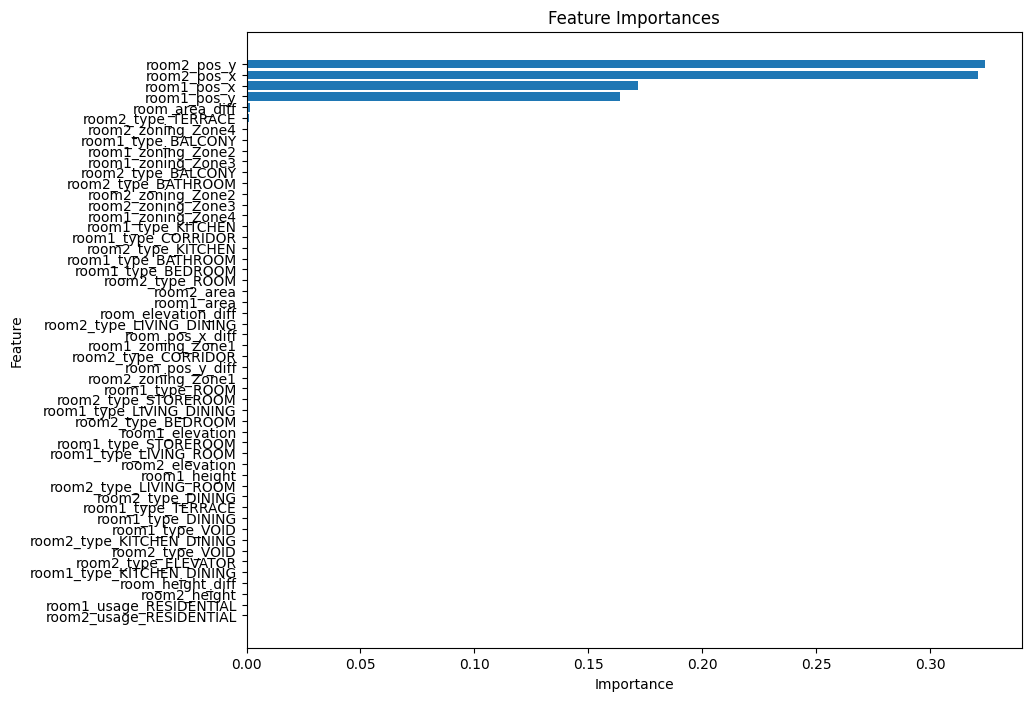

In [176]:
def plot_feature_importances(pipeline, preprocessor):
    # Extract the individual XGBoost models from the MultiOutputRegressor
    xgb_models = pipeline.named_steps['regressor'].estimators_

    # Get feature importances from each XGBoost model and average them
    feature_importances = np.mean([model.feature_importances_ for model in xgb_models], axis=0)

    # Get feature names from the preprocessor
    numeric_features = preprocessor.transformers_[0][2]
    categorical_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(preprocessor.transformers_[1][2])
    feature_names = np.concatenate([numeric_features, categorical_features])

    # Create a DataFrame for feature importances
    importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    importances_df = importances_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 8))
    plt.barh(importances_df['Feature'], importances_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

    return importances_df

# Call the function
importances_df = plot_feature_importances(best_xgb_regr, preprocessor)

In [178]:
importances_df.head(5)

,Feature,Importance
9,room2_pos_y,0.323872
8,room2_pos_x,0.321055
6,room1_pos_x,0.171579
7,room1_pos_y,0.163820
10,room_area_diff,0.001577


Retrain a model on just the most important 5 features

In [179]:
pd.set_option('display.max_columns', None)
X.head(5)

,room1_area,room2_area,room1_elevation,room2_elevation,room1_height,room2_height,room1_type,room2_type,room1_zoning,room2_zoning,room1_usage,room2_usage,room1_pos_x,room1_pos_y,room2_pos_x,room2_pos_y,room_area_diff,room_height_diff,room_elevation_diff,room_pos_x_diff,room_pos_y_diff
0,6.554867,12.222848,5.8,5.8,2.6,2.6,BATHROOM,CORRIDOR,Zone3,Zone2,RESIDENTIAL,RESIDENTIAL,-3.897456,-11.451412,-0.429371,-12.760799,-5.667981,0.0,0.0,-3.468084,1.309387
1,8.830383,11.498035,5.8,5.8,2.6,2.6,BALCONY,KITCHEN,Zone4,Zone2,RESIDENTIAL,RESIDENTIAL,-2.830958,-19.340856,-2.429643,-16.669991,-2.667652,0.0,0.0,-0.401315,-2.670865
2,18.889749,12.222848,5.8,5.8,2.6,2.6,LIVING_ROOM,CORRIDOR,Zone2,Zone2,RESIDENTIAL,RESIDENTIAL,-5.774462,-15.261604,-0.429371,-12.760799,6.666901,0.0,0.0,-5.345090,-2.500805
3,8.064509,26.193672,8.7,8.7,2.6,2.6,CORRIDOR,LIVING_DINING,Zone2,Zone2,RESIDENTIAL,RESIDENTIAL,2.275675,0.775972,5.903438,-1.895795,-18.129163,0.0,0.0,-3.627762,2.671767
4,8.064509,16.564667,8.7,8.7,2.6,2.6,CORRIDOR,BEDROOM,Zone2,Zone1,RESIDENTIAL,RESIDENTIAL,2.275675,0.775972,5.738338,3.392873,-8.500158,0.0,0.0,-3.462663,-2.616901


In [180]:
num_best = 5
best_features = (importances_df['Feature'][:num_best]).to_list()
best_features

['room2_pos_y', 'room2_pos_x', 'room1_pos_x', 'room1_pos_y', 'room_area_diff']

In [181]:
X_limited = X[best_features]
X_limited.head(5)

,room2_pos_y,room2_pos_x,room1_pos_x,room1_pos_y,room_area_diff
0,-12.760799,-0.429371,-3.897456,-11.451412,-5.667981
1,-16.669991,-2.429643,-2.830958,-19.340856,-2.667652
2,-12.760799,-0.429371,-5.774462,-15.261604,6.666901
3,-1.895795,5.903438,2.275675,0.775972,-18.129163
4,3.392873,5.738338,2.275675,0.775972,-8.500158


In [182]:
# Define preprocessing steps
numeric_features = ['room1_pos_x', 'room1_pos_y', 'room2_pos_x', 'room2_pos_y', 'room_area_diff']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features)
    ])

# Create a pipeline with the preprocessor and a MultiOutputRegressor with XGBRegressor
xgb_regr_limited = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(XGBRegressor(random_state=42)))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_limited, y, test_size=0.2, random_state=42)

In [185]:
best_params = {'regressor__estimator__learning_rate': 0.1, 'regressor__estimator__max_depth': 7, 'regressor__estimator__min_child_weight': 3, 'regressor__estimator__n_estimators': 300}

xgb_regr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(XGBRegressor(
        n_estimators=best_params['regressor__estimator__n_estimators'],
        max_depth=best_params['regressor__estimator__max_depth'],
        learning_rate=best_params['regressor__estimator__learning_rate'],
        min_child_weight=best_params['regressor__estimator__min_child_weight'],
        random_state=42
    )))
])

# Initialize lists to store training sizes and R² scores
training_sizes = []
r2_scores = []

# Loop through increasingly large portions of the dataset (10% more of dataset each time) ~ 20 mins
for i in range(1, 1001):
    # Calculate the size of the training set
    train_size = int(len(X_train) * (i / 1000))
    training_sizes.append(train_size)

    # Train the model with curr size
    xgb_regr.fit(X_train[:train_size], y_train[:train_size])

    # Predict on test set
    y_pred = xgb_regr.predict(X_test)

    # Calculate test R² score
    test_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    r2_scores.append(test_r2)
    # print(f"Test R^2 score: {test_r2}")

Testing how many datapoints are needed for good quality results

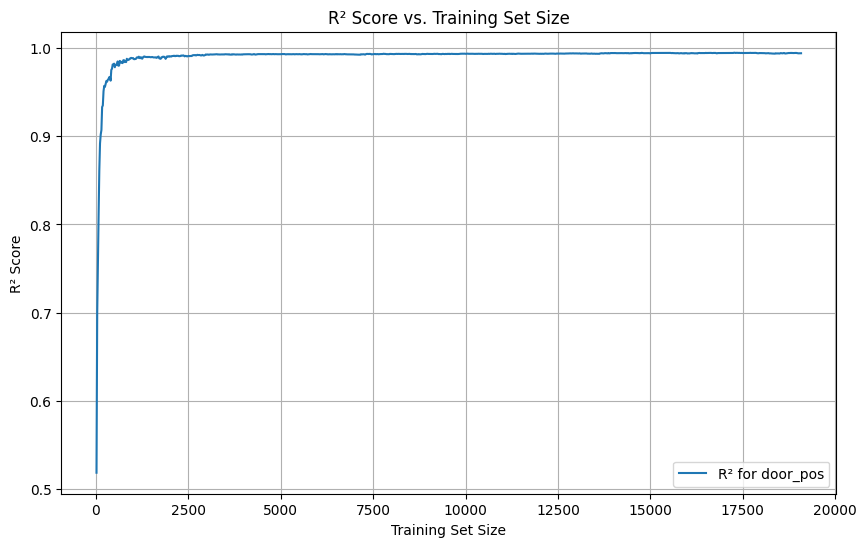

In [186]:
# Plot the R² scores
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, r2_scores, label='R² for door_pos')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title('R² Score vs. Training Set Size')
plt.legend()
plt.grid(True)
plt.show()

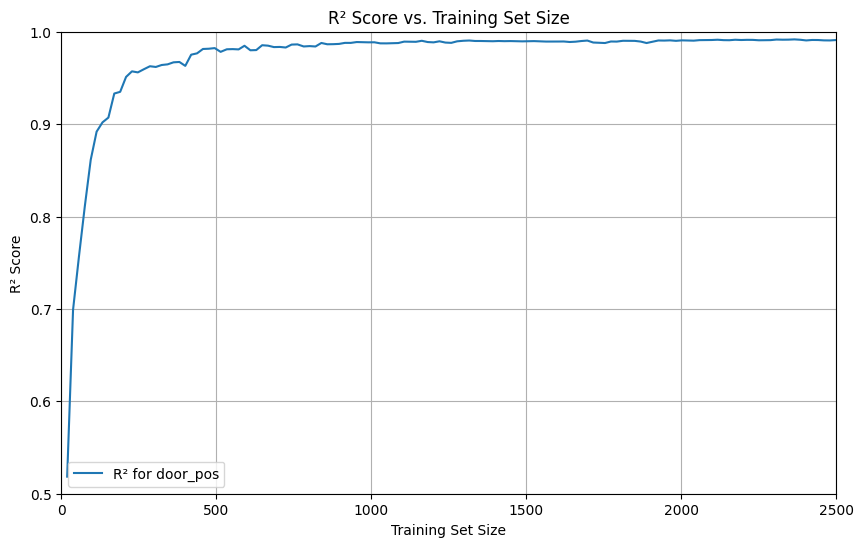

In [187]:
# Plot the R² scores (zoomed in)
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, r2_scores, label='R² for door_pos')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title('R² Score vs. Training Set Size')
plt.xlim(0, 2500)
plt.ylim(0.5, 1)
plt.legend()
plt.grid(True)
plt.show()

Thresholds for min number of data points to reach certain R² score

In [188]:
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99]
indices = np.array([find_first_index_greater_than_x(r2_scores, x) for x in thresholds])

# Ensure indices are valid
valid_indices = indices[indices >= 0]

# Make df
df = pd.DataFrame({
    'Training Size': np.array(training_sizes)[valid_indices],
    'R² Score': np.array(r2_scores)[valid_indices]
})

df

,Training Size,R² Score
0,19,0.518488
1,38,0.699091
2,57,0.756666
3,76,0.811260
4,133,0.901923
5,209,0.951088
6,457,0.981322
7,1163,0.990195


Observe first 500 datapoints in greater detail

In [193]:
# Initialize lists to store training sizes and R² scores
training_sizes_500 = []
r2_scores_500 = []

# Loop through increasingly large portions of the dataset (10% more of dataset each time)
for i in range(1, 500):
    # Calculate the size of the training set
    train_size = i
    training_sizes_500.append(train_size)

    # Train the model with curr size
    xgb_regr.fit(X_train[:train_size], y_train[:train_size])

    # Predict on test set
    y_pred = xgb_regr.predict(X_test)

    # Calculate test R² score
    test_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    r2_scores_500.append(test_r2)
    # print(f"Test R^2 score: {test_r2}")

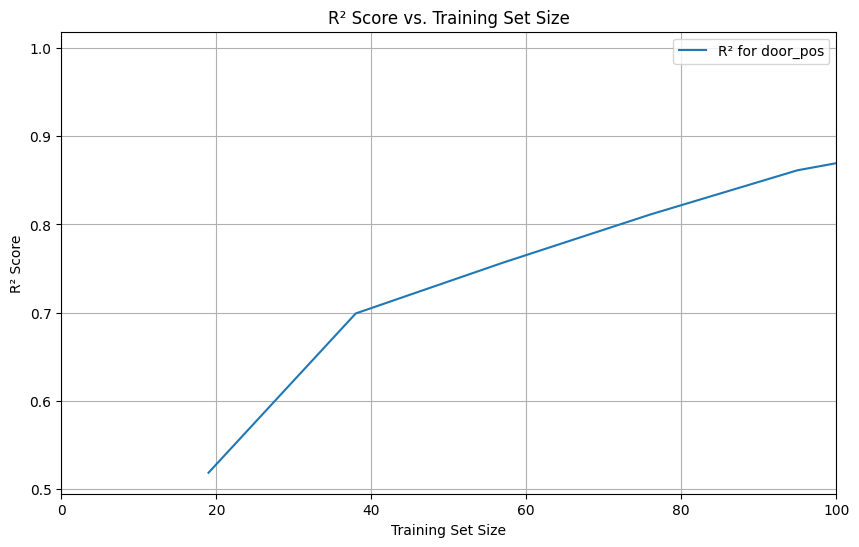

In [194]:
# Plot the R² scores
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, r2_scores, label='R² for door_pos')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title('R² Score vs. Training Set Size')
plt.xlim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

In [191]:
# Observe thresholds

# First index greater than various thresholds summary
def find_first_index_greater_than_x(lst, x):
    arr = np.array(lst)
    indices = np.where(arr > x)[0]
    return indices[0] if indices.size > 0 else -1

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
indices = np.array([find_first_index_greater_than_x(r2_scores_500, x) for x in thresholds])

# Ensure indices are valid
valid_indices = indices[indices >= 0]

# Make df
df = pd.DataFrame({
    'Training Size': np.array(training_sizes_500)[valid_indices],
    'R² Score': np.array(r2_scores_500)[valid_indices]
})

df

,Training Size,R² Score
0,18,0.517269
1,21,0.622829
2,36,0.700112
3,73,0.808183
4,126,0.903125
5,199,0.950700
6,453,0.981171


**Combine Models into 1 Function**

In [195]:
# Returns None if the rooms aren't connected, returns the door position if they are
def predict_connection_door_pos(room1_id, room2_id):
    # If there is no connection, return none
    if (predict_connection(room1_id, room2_id) == None):
        return None
    # Otherwise predict the door position
    else:
        return predict_door_position(room1_id, room2_id)

In [196]:
# Usage
# Connected
room1_id = 192724
room2_id = 192725
print(predict_connection_door_pos(room1_id, room2_id))

[-10.673875 -28.456398]


In [197]:
# Not Connected
room1_id = 82938
room2_id = 192725
print(predict_connection_door_pos(room1_id, room2_id))

Rooms with IDs 82938 and 192725 not found in the same apartment.
None


**Close GDS connection**

In [39]:
# Close the GDS connection
gds.close()